# Finding the frauds

### This Ipython notebook aims to find out all the likely fraudsters based on certain features and user behavior.

In [360]:
# importing all the necessary packages 

import pandas as pd
import numpy as np
import os
from file import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Loading the data from csv files to dataframes using pandas

In [361]:
currency_df = pd.read_csv(os.path.join(dir_path, './fct_data/currency_details.csv'))
fx_df = pd.read_csv(os.path.join(dir_path, './fct_data/fx_rates.csv'))
trans_df = pd.read_csv(os.path.join(dir_path, './fct_data/transactions.csv'), index_col=0)
users_df = pd.read_csv(os.path.join(dir_path, './fct_data/users.csv'), index_col=0)
fraudster_df = pd.read_csv(os.path.join(dir_path, './fct_data/fraudsters.csv'), index_col=0)


Converting the column headers to lowercase

In [362]:
currency_df.columns = map(str.lower, currency_df.columns)
fx_df.columns = map(str.lower, fx_df.columns)
trans_df.columns = map(str.lower, trans_df.columns)
users_df.columns = map(str.lower, users_df.columns)

# Explore the data
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 688651 entries, 0 to 704881
Data columns (total 11 columns):
currency             688651 non-null object
amount               688651 non-null int64
state                688651 non-null object
created_date         688651 non-null object
merchant_category    223065 non-null object
merchant_country     483073 non-null object
entry_method         688651 non-null object
user_id              688651 non-null object
type                 688651 non-null object
source               688651 non-null object
id                   688651 non-null object
dtypes: int64(1), object(10)
memory usage: 63.0+ MB


### Exploratory Data Analysis

Combining the fraudsters with the user and transaction dataframes so that we can compare both fraudsters and normal users simultaneously.
Adding an extra column called [is_fraud] which has binary data 0 and 1. 1 for frauds and 0 for normal users.

In [363]:
trans_df['is_fraud'] = 0
users_df['is_fraud'] = 0
fraudster_df['is_fraud'] = 1

trans_df['is_fraud'] = trans_df['user_id'].isin(fraudster_df['user_id'])
trans_df['is_fraud'][trans_df['is_fraud'] == 1] = 1
trans_df['is_fraud'] = trans_df['is_fraud'].astype(int)

users_df['is_fraud'] = users_df['id'].isin(fraudster_df['user_id'])
users_df['is_fraud'][users_df['is_fraud'] == 1] = 1
users_df['is_fraud'] = users_df['is_fraud'].astype(int)


### Aim: We need to finalize the features and data points which can lead us to fraudsters in the system.

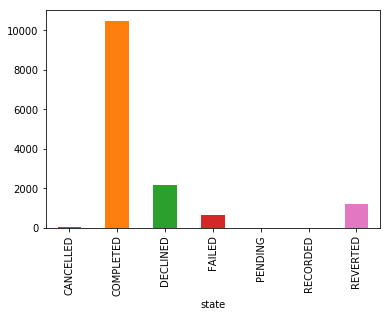

In [364]:
#  plotting to check if the state of the transaction has any effect on fraudulent transactions
trans_df[trans_df['is_fraud'] == 1].groupby('state').count()["is_fraud"].plot(kind = "bar")


In [365]:
# checking for KYC as it is a very important factor for user identification and authorization

fr_user_df = pd.merge(users_df, fraudster_df, left_on = "id", right_on = "user_id", how = "left")
users_df[users_df['is_fraud']==1].groupby('kyc').count()

,failed_sign_in_attempts,birth_year,country,state,created_date,terms_version,phone_country,has_email,id,is_fraud
kyc,,,,,,,,,,
FAILED,22,22,22,22,22,13,22,22,22,22
NONE,1,1,1,1,1,0,1,1,1,1
PASSED,260,260,260,260,260,206,260,260,260,260
PENDING,17,17,17,17,17,13,17,17,17,17


In [366]:
# checking for number of failed_sign_in_attempts
users_df[users_df['is_fraud']==1].groupby('failed_sign_in_attempts').count()

,kyc,birth_year,country,state,created_date,terms_version,phone_country,has_email,id,is_fraud
failed_sign_in_attempts,,,,,,,,,,
0,297,297,297,297,297,229,297,297,297,297
1,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2


Thus, failed Sign in attempts doesn't reflect much on a fraudulent transaction.

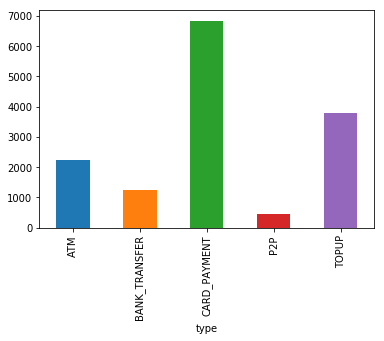

In [367]:
# type of transactions relation to number of fraudulent transactions

trans_df[trans_df['is_fraud']==1].groupby('type').count()['is_fraud'].plot(kind="bar")

As can be seen in the above bar plot, CARD_PAYMENT and TOPUP are the 2 most used payment methods which are used in a fraudulent transactions.

## Question 2(a)

### Approach to find the fraudsters

Looking at the data and EDA results on different parameters, we must first list down all the potential features which are crucial in the process of a transaction. Listing down all the important factors which can provide some leads:
1. KYC - Legal Identification status of the user
2. has_email - if the user has a registered email in our database
3. state - Is he active or passive or locked?
4. Merchant country - Look at the country to which the amount is being transferred

Now, we need to build a potential scenario by knitting together all the above parameters.
We are basically testing the user's authenticity from all the parameters mentioned above.

Logic behind declaring someone as a Fraudster:
- If a user has its KYC failed with no email address registered and is actively using our platform.
- Above this, check if the country is recorded in the transaction to which the transfer has been made.

In [368]:
# finding out all the unidentified users who have their KYC failed
unidentified_df = users_df.query('kyc == "FAILED" and has_email == 0 and state == "ACTIVE"')

# merging(joining) the above dataframe with the transactional database on user_id
unidentified_txns = pd.merge(unidentified_df, trans_df, left_on='id', right_on='user_id')

unidentified_txns.head()

,failed_sign_in_attempts,kyc,birth_year,country,state_x,created_date_x,terms_version,phone_country,has_email,id_x,...,state_y,created_date_y,merchant_category,merchant_country,entry_method,user_id,type,source,id_y,is_fraud_y
0,0,FAILED,1966,GB,ACTIVE,2015-11-06 12:39:34.355000,NaN,GB||JE||IM||GG,0,62edb2a5-8b28-466a-9a9a-b3e314f2f771,...,DECLINED,2015-11-17 20:30:33.796000,NaN,NaN,misc,62edb2a5-8b28-466a-9a9a-b3e314f2f771,ATM,GAIA,9d99f7f9-ba47-42e4-8151-a5a2aef27f96,0
1,0,FAILED,1993,GE,ACTIVE,2015-10-18 07:02:26.487000,NaN,GE,0,f6b7f148-bb9f-42c9-9c56-9243f83ee3d5,...,FAILED,2015-11-10 20:26:34.738000,NaN,NaN,misc,f6b7f148-bb9f-42c9-9c56-9243f83ee3d5,TOPUP,NYX,d659b109-0509-49b1-af70-b9a2158b33a4,0
2,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,COMPLETED,2015-09-24 11:31:29.321000,NaN,ITA,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,CARD_PAYMENT,GAIA,e60174ba-59d1-4084-bcbe-43152f7d22e4,0
3,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,COMPLETED,2015-09-27 08:25:57.976000,NaN,ITA,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,CARD_PAYMENT,GAIA,74d947bd-49e9-42f4-ba74-e18d86fa29d9,0
4,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,COMPLETED,2015-09-27 14:18:17.138000,point_of_interest,GBR,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,CARD_PAYMENT,GAIA,65c7a581-6cbd-4202-9666-f67791ae6c7d,0


Among the unidentified users, we will check for their transactional data to check for the merchant country. If the country to which the transfer has been made is captured. Narrowing down the list of users who are most likely to be frauds.

In [369]:
# checking for NaN values in the merchant_country column in the above obtained dataframe and since TOPUP corresponds
# to financial loss, any transaction by an unauthorized user should not be using this method of transaction.

frauds_df = unidentified_txns.query('merchant_country.isnull() and merchant_country.isnull() and type == "TOPUP"')
frauds_df.head()

,failed_sign_in_attempts,kyc,birth_year,country,state_x,created_date_x,terms_version,phone_country,has_email,id_x,...,state_y,created_date_y,merchant_category,merchant_country,entry_method,user_id,type,source,id_y,is_fraud_y
1,0,FAILED,1993,GE,ACTIVE,2015-10-18 07:02:26.487000,NaN,GE,0,f6b7f148-bb9f-42c9-9c56-9243f83ee3d5,...,FAILED,2015-11-10 20:26:34.738000,NaN,NaN,misc,f6b7f148-bb9f-42c9-9c56-9243f83ee3d5,TOPUP,NYX,d659b109-0509-49b1-af70-b9a2158b33a4,0
12,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,FAILED,2015-09-12 17:54:05.164000,NaN,NaN,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,TOPUP,NYX,a273f810-5164-4add-a1c9-415c02fe0bd5,0
23,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,FAILED,2015-09-12 17:53:19.285000,NaN,NaN,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,TOPUP,NYX,0093eb87-1d9b-4b55-96b1-8e66f49c1e49,0
24,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,FAILED,2015-09-13 08:47:18.607000,NaN,NaN,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,TOPUP,NYX,9123565c-31f5-4570-b8d8-c7d5b25b2b5d,0
25,0,FAILED,1981,GB,ACTIVE,2015-08-09 07:33:29.491000,NaN,GB||JE||IM||GG,0,82a2ecd2-0b94-4629-85c0-141d7af04e5f,...,COMPLETED,2015-09-13 10:15:08.022000,NaN,NaN,misc,82a2ecd2-0b94-4629-85c0-141d7af04e5f,TOPUP,OPHION,195826d8-73f3-4e72-a6dc-c784819dec18,0


We have the frauds which are:
1. Not KYC compliant
2. No email registered
3. Are active on the app
4. Don't have the merchant country mentioned.
5. Using TOPUP type transaction

Next, we need to take into account the users who are transacting frequency is over a threshold. This is going to account for any script or backend attack.

In [370]:
# We will be converting the datetime column into simple date column in the transaction dataframe
# to learn about the number of transactions per day.

trans_df['created_date'] = trans_df['created_date'].astype('datetime64[s]').dt.date
freq_trans_df = trans_df.groupby(['created_date', 'user_id']).count()

# Now marking users who are doing more than 30 transactions in a day.
a = freq_trans_df[freq_trans_df['amount'] > 50].reset_index(level=0, drop=True)
freq_txn_user_ids = a.index.unique()
list(freq_txn_user_ids)

['ec4fd825-7167-450b-aa9f-0cbcf681978b',
 '1e3ad24b-8818-4db9-82fb-a0c30fc5b35a',
 '073abac2-836b-4964-9005-d0aed492cd96',
 'abfc3bdc-f09c-4eff-982c-fb8af72b07ad',
 'a24b204c-3b6a-446a-8b06-20dd150a4805']

### Removing all the already obtained fraudsters in the list

In [371]:
fraud_id_set = set(frauds_df['id_x'])
potential_fraudsters = fraud_id_set - set(fraudster_df['user_id'])

In [372]:
# Here is the final list of potential fraudsters on our platform.
potential_fraudsters

{'146cb748-d9a7-410a-b2ec-f5c403f7149d',
 '16102a27-534e-48d7-b7d2-99e08e6c7597',
 '1eb7c725-f748-4e76-98cc-1bb6b58d4e4a',
 '5302559e-9dbd-4f1d-ba3b-4e5a10f0e51a',
 '5ff27f1c-65e2-426f-a139-56d7cf6f4a42',
 '78a0cfa2-f9d3-4f07-94c4-a97f76595589',
 '82a2ecd2-0b94-4629-85c0-141d7af04e5f',
 'acbb5850-8df2-4614-a277-83e020a9edc9',
 'c876e9f6-c0f8-4ee6-80a0-2a9ef751cc80',
 'ccc08947-8246-45c3-ae88-8f9327b60a74',
 'd1e9aea4-e0e3-4ac3-af74-f8095c8b8861',
 'd4aee110-f821-4545-b617-1f49eacad2b9',
 'dd8e1dd7-e467-41ff-908f-4e0ab64d9af3',
 'e0ff10b4-4e05-45c8-9183-ab45ae37913e',
 'e14f2def-d412-4ba6-90da-6ff8c8bf2782',
 'f6b7f148-bb9f-42c9-9c56-9243f83ee3d5'}

# =============================================================

## Question 2(b)

### Now, there are some high risk users who are transacting heavily big amounts. These will be bucketed as high risk users.

In [373]:
# Among the above high frequency users, we will mark those who are making transactions above 450000
# Now marking users who are doing more than 30 transactions in a day.

# We will be converting the datetime column into simple date column in the transaction dataframe
# to learn about the number of transactions per day.
risky_users = freq_trans_df[freq_trans_df['amount'] > 50].reset_index(level=0, drop=True)
freq_txn_user_ids = risky_users.index.unique()
list(freq_txn_user_ids)

df = pd.DataFrame({'user_id':list(freq_txn_user_ids)})
big_risk_df = pd.merge(df, trans_df, on='user_id', how='left')
big_risk_df = big_risk_df[big_risk_df['amount'] > 500000]
high_risk_users = big_risk_df['user_id'].unique()
high_risk_users

array(['dc283b17-bbe1-4ae9-a11c-0029d5ae71d9',
       '1e3ad24b-8818-4db9-82fb-a0c30fc5b35a',
       '0bed6203-0ed0-4e40-8f9c-e52ed7dedb6a',
       'a275b394-b1fa-494e-b6f7-010c5e17f7c6',
       '4f41a015-5205-467d-98d6-a90d343e8afb',
       'a51d33e2-82ac-4556-ba1b-7364bc9ae8f5',
       '1ac43c83-6c00-41cb-943c-7279a79ff2aa'], dtype=object)

In [374]:
high_pot_fraudsters = set(high_pot_frauds_df['id_x']).union(set(high_risk_users)) - set(fraudster_df['user_id'])
high_pot_fraudsters

{'16102a27-534e-48d7-b7d2-99e08e6c7597',
 '1e3ad24b-8818-4db9-82fb-a0c30fc5b35a',
 'a275b394-b1fa-494e-b6f7-010c5e17f7c6',
 'a51d33e2-82ac-4556-ba1b-7364bc9ae8f5'}

### Ids of the high risk users.

In [375]:
high_pot_fraudsters

{'16102a27-534e-48d7-b7d2-99e08e6c7597',
 '1e3ad24b-8818-4db9-82fb-a0c30fc5b35a',
 'a275b394-b1fa-494e-b6f7-010c5e17f7c6',
 'a51d33e2-82ac-4556-ba1b-7364bc9ae8f5'}

## Financial crime Typology and Due Diligence

For high risk users who are transacting heabily on the app with more than 45 transactions in a day and all of them being a very large amount(more than 500000 which is huge even ):

The crime typology associated with the above users are:
1. Structuring (smurfing): A method involving numerous transactions (deposits, withdrawals, transfers), often various people, high volumes of transactions and sometimes numerous accounts to avoid detection threshold reporting obligations.
2. Bust out: Here the hackers and thieves create accounts, make a large number of transactions until they are caught and locked out.
3. Cash couriers / currency smuggling: concealed movement of currency to avoid transaction / cash reporting measures. To quickly move large amount of currency out of the country as it beomes difficul to get back the amount once it is transferred overseas.


### For potential fraudsters:

We have clearly focused on the legal identification of the user to be able to transact the money.

Users who don't have their KYC done, we don't have any record or method to:
- keep track of their source of income
- assess further potential risks like money laundering, concealment of businesses and other internet sourced frauds.
- make sure that all our clients are anti-bribery compliant
- to put in place an anti-corruption due diligence 

Keeping in mind the above mentioned crucial factors, here is how we can conduct due diligence on these high risk users:
1. Revoking their permission to make any transaction before they get their KYC PASSED.
2. Streamline the process of getting a KYC as most of the users are opt out because of this obligation. We need to incorporate the compliance without harming the business.
3. For an amount greater than 20000, Merchant's country should be made mandatory to be supplied.
4. Email should be verified along with the phone number.
5. All the tax reciepts / PAN(Anti-corruption information) card details should be verified. 


# ============================================================

## Question 3(a)

Exploring the already figured fraudsters in the fraudsters.csv. Mapping the relationships between fraudsters, users and transactions files.

Steps to perform EDA(Exploratory Data Analysis) which is done at the starting of the 

1. Pick up an id from the fraudsters file and run it over in the users and transactions file.
2. Look for a pattern which is common or an anomaly in all the columns in the two files.
3. To make it easy, we'll merge the fraudsters dataframe with the users df to explore the fraudsters' user details.
4. We'll also have a merge of fraudsters and transactions dataframe to understand the fraudsters transaction pattern.


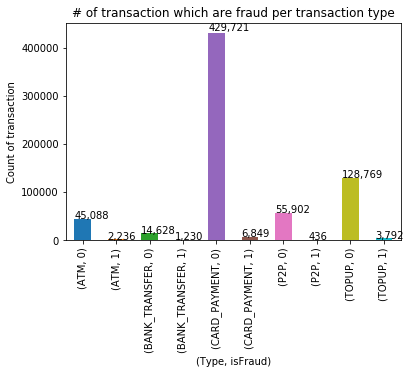

In [376]:
ax = trans_df.groupby(['type', 'is_fraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

As can be seen in the above bar plot, most number of fradulent transactions are from CARD_PAYMENT which because it is also the most used transaction type. But let's take a look at the percentages here:
1. Percentage of TOPUPs which are fraudulent = 56 / 132505 * 100 = 0.04%
2. Percentage of CARD_PAYMENT which are fraudulent = 128 / 436442 * 100 = 0.02%

Thus, these percentages are not giving a conclusive picture which can help us decide a concrete 

In [377]:
# Merging the fraudster dataframe with the transaction to understand the transaction patterns of fraudsters.

fr_txn_df = pd.merge(fraudster_df, trans_df, on="user_id", how = "left")

"""
get the ids of the users who have:
1. transacted more than 700000 in amount,
2. Don't have the merchant country specified
""" 
ids = trans_df.query('amount > 700000 and type == "CARD_PAYMENT"')['user_id'].unique()
len(set(ids).intersection(set(fraudster_df['user_id'])))

1

### Reasoning #1 for understanding the factors mentioned above

So, we can see that almost half of the fraudsters are those who have transacted an amount of more than 100000 and have their merchant country unspecified. The type of all of these large amount of transaction is Topup.

Why are these factors important?

1. Making a large amount transaction with no merchant country specified can lead to many cases of money laundering.
2. When a large transaction is being made, there is a huge risk in a TopUP transaction.

,currency,amount,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,is_fraud
state,,,,,,,,,,,
CANCELLED,20,20,20,0,0,20,20,20,20,20,20
COMPLETED,10484,10484,10484,3311,6302,10484,10484,10484,10484,10484,10484
DECLINED,2187,2187,2187,564,2124,2187,2187,2187,2187,2187,2187
FAILED,659,659,659,0,0,659,659,659,659,659,659
PENDING,6,6,6,1,1,6,6,6,6,6,6
RECORDED,2,2,2,0,2,2,2,2,2,2,2
REVERTED,1185,1185,1185,250,650,1185,1185,1185,1185,1185,1185


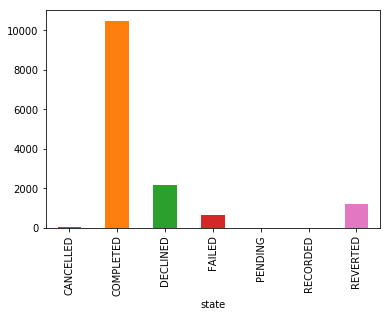

In [378]:
#  plotting to check if the state of the transaction has any effect on fraudulent transactions
trans_df[trans_df['is_fraud'] == 1].groupby(['state']).count()["is_fraud"].plot(kind = "bar")
trans_df[trans_df['is_fraud'] == 1].groupby(['state']).count()

### Reasoning #2 for understanding the state of the transactions

The data is highly imbalances as can be seen from the graph which is always the case in fraud detection. But we can see that there are a number declined transactions which have been marked as fraudulent.

Nothing too concrete from here but we can take a look at the number of declined transaction

### Looking at the number of transactions done by a user in a day

In [379]:
# Grouping by created_date and user_id in the transaction dataframes.

trans_df['created_date'] = trans_df['created_date'].astype('datetime64[s]').dt.date
freq_frd_txn_df = trans_df.groupby(['created_date', 'user_id']).count()

# for over 10 transactions in a day by a normal user
freq_frd_txn_df = freq_frd_txn_df[freq_frd_txn_df['amount'] > 10].reset_index(level=0, drop=True)
usr_ids = freq_frd_txn_df.index.unique()
len(set(usr_ids).intersection(set(fraudster_df['user_id'])))

81

### Reasoning #3 for understanding the frequency of transactions

A very crucial factor in the transactional data is the number of transactions done by a user because of the following attacks:

`81 out of 300 fraudsters are doing more than 10 transactions in a day`

1. There may be a malicious bot/script running which is making the transactions.
2. To capture all the bust out frauds: Users do this to make their credit score where they process as many fraudulent transactions as possible within a short amount of time, and before being caught.

## Features indicative of detecting fraudsters:

1. Frequency of transactions per day.
2. The amount of the transaction and the type of transaction.
3. Merchant's country
4. State of the transaction



# ==============================================================

## Question 3(b)

Two items that we'll need from the data team to better detect the fraudsters are:

1. Information about the merchant ids and business, this can be publicly available authentic data. - One of the most common frauds in the industry today is Transaction laundering and until and unless we strictly monitor the merchants to whom the transaction is being made, there will not be a concrete evidence against the fraudster.

2. Details of users' account balance to record and aggregate the behavior. Their privileges/permissions(if any) on the platform.  - This will help us conduct enhanced due diligence and set up a clear boundaries for each type of users. 

# ==============================================================